# **Weather Classification using Transfer Learning**

## About the Dataset

The dataset has been downloaded from Kaggle.\
Link to dataset: [Multiclass Weather Dataset](https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset)

The dataset contains 6-folders: 5-folders having each category of images and one with the `alien_test` having the images of all categories. It also consist a `test.csv` file having the labels for the images in alien_test folder.

### Description
The data has been collected from internet and the images of interest containing Creative Commons license retrieved from Flickr, Unsplash and Pexels have been used. Different images are subject to different types of licenses.

The dataset features 5 different classes of weather collected from the above said different sources, however it's real life data so any system for weather classification must be able to handle this sort of images. The dataset contains about 1500 labelled images including the validation images. Images are not of fixed dimensions and the photos are of different sizes. Each image has only one weather category and are saved in separate folder as of the labelled class.
Each image have been rated for the weather condition on a scale of 0 to 4:

0 - cloudy\
1 - foggy\
2 - rainy\
3 - shine\
4 - sunrise.

## Visualize the Images

Let's visualize few images from each folder to get a feel about the type of images it contains. 

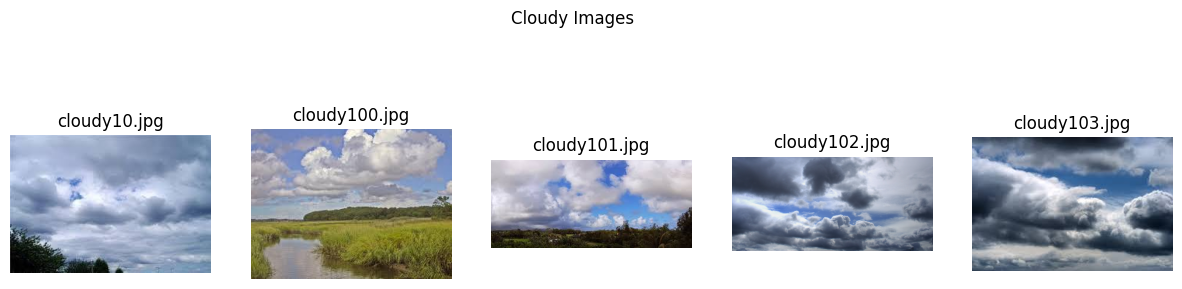

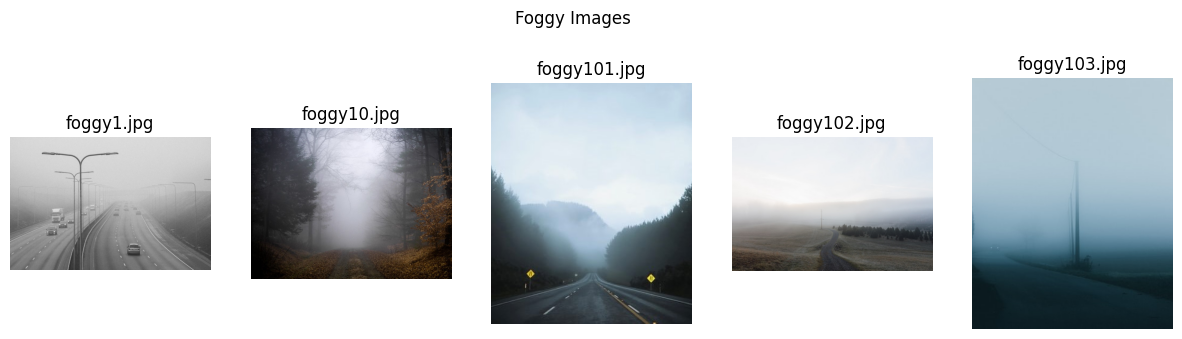

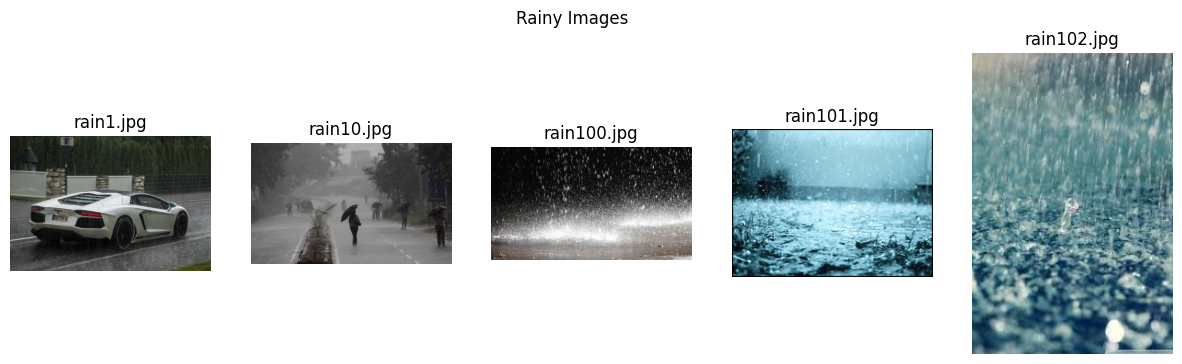

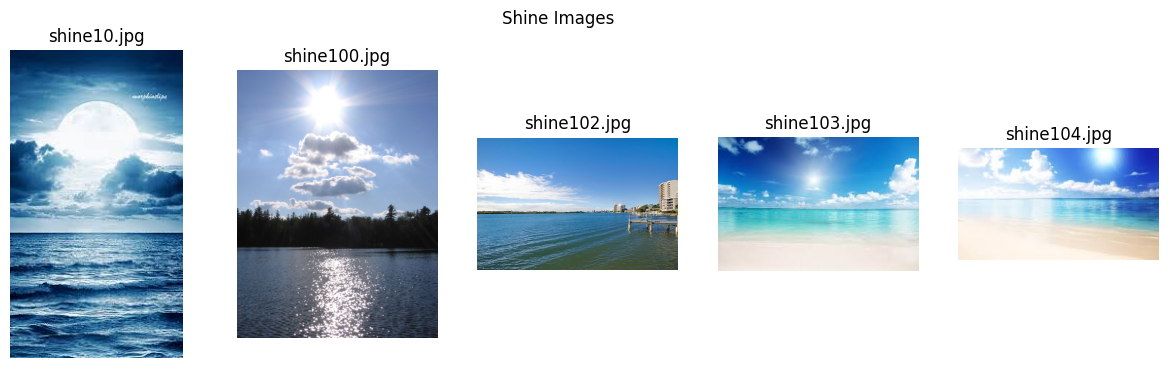

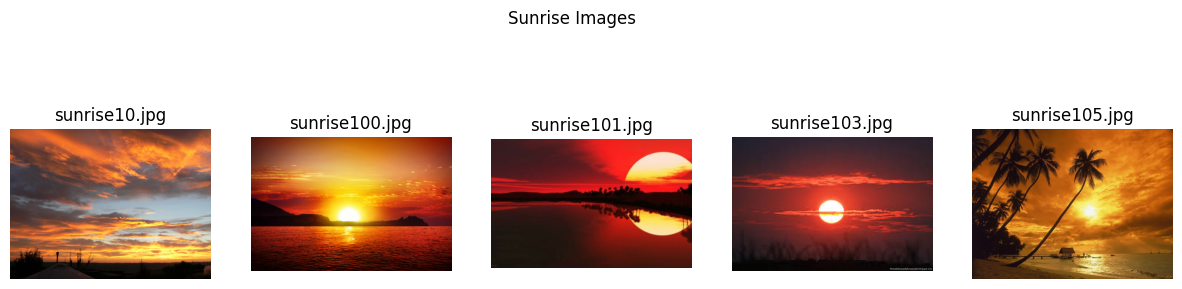

In [57]:
import os
import matplotlib.pyplot as plt
import cv2 # openCV

# Function to plot images from a folder
def plot_images_from_folder(folder_path, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # Adjust the number of subplots as needed
    
    # Iterate through the first 5 images in the folder
    for i, filename in enumerate(os.listdir(folder_path)[:5]):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(filename)
        axes[i].axis('off')
    
    fig.suptitle(title)
    plt.show()

# Paths to folders containing images
folders = ['train/cloudy', 'train/foggy', 'train/rainy', 'train/shine', 'train/sunrise']
titles = ['Cloudy Images', 'Foggy Images', 'Rainy Images', 'Shine Images', 'Sunrise Images']

# Plot images from each folder
for folder, title in zip(folders, titles):
    plot_images_from_folder(folder, title)

## Organize the Folder Structure

The training data is present in five folders namely `cloudy`, `foggy`, `rainy`, `shine`, and `sunrise`. We need to organize the images into separate `train` and `test` folders after splitting them in `80:20` ratio. We'll keep 80% images from each folder for training and 20% for testing.    

In [12]:
import shutil
import random

# Path to your dataset
dataset_path = 'dataset'

# Define the split ratio
train_ratio = 0.8

# Create directories for train and test sets
train_dir = 'train'
test_dir = 'test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List of the directories for splitting the data
directory_list = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

# Loop through each class directory
for class_name in directory_list:

    class_dir = os.path.join(dataset_path, class_name)
    print("Splitting", class_dir, "...")
    
    if os.path.isdir(class_dir):

        # Create subdirectories for train and test sets
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        # Get list of images in the class directory
        images = os.listdir(class_dir)
        
        # Calculate the number of images for training
        num_train = int(len(images) * train_ratio)
        
        # Randomly select images for training
        train_images = random.sample(images, num_train)
        
        # Move images to train directory
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_class_dir, image)
            shutil.copyfile(src, dst)
        
        # Move remaining images to test directory
        for image in images:
            if image not in train_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(test_class_dir, image)
                shutil.copyfile(src, dst)

print("Dataset split into train and test sets successfully.")

Splitting dataset\cloudy ...
Splitting dataset\foggy ...
Splitting dataset\rainy ...
Splitting dataset\shine ...
Splitting dataset\sunrise ...
Dataset split into train and test sets successfully.


## Transfer Learning using **VGG19** Model

We'll use the **VGG19** Model as our base model for image classification.\
We'll train our custom model on 10 epochs.

In [59]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define directories for train and test data
train_dir = 'train'
test_dir = 'test'

# Define image dimensions and batch size
img_width, img_height = 224, 224 # Recommended image dimensions for VGG19 Model
batch_size = 16

# Create data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

# Load pre-trained VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new sequential model
model = Sequential()

# Add the VGG19 base model
model.add(base_model)

# Flatten the output of the VGG19 base model
model.add(Flatten())

# Add custom top layers for classification
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

Found 1200 images belonging to 5 classes.
Found 300 images belonging to 5 classes.
80134624/80134624 [==============================] - 25s 0us/step


Epoch 1/10
75/75 [==============================] - 396s 5s/step - loss: 1.7048 - accuracy: 0.5058 - val_loss: 0.7878 - val_accuracy: 0.7633
Epoch 2/10
75/75 [==============================] - 436s 6s/step - loss: 0.9195 - accuracy: 0.6283 - val_loss: 0.7259 - val_accuracy: 0.7533
Epoch 3/10
75/75 [==============================] - 355s 5s/step - loss: 0.8171 - accuracy: 0.6883 - val_loss: 0.5614 - val_accuracy: 0.8100
Epoch 4/10
75/75 [==============================] - 464s 6s/step - loss: 0.7511 - accuracy: 0.6892 - val_loss: 0.5059 - val_accuracy: 0.8133
Epoch 5/10
75/75 [==============================] - 578s 8s/step - loss: 0.6531 - accuracy: 0.7383 - val_loss: 0.4932 - val_accuracy: 0.8367
Epoch 6/10
75/75 [==============================] - 517s 7s/step - loss: 0.6581 - accuracy: 0.7292 - val_loss: 0.5373 - val_accuracy: 0.8067
Epoch 7/10
75/75 [==============================] - 498s 7s/step - loss: 0.6108 - accuracy: 0.7500 - val_loss: 0.5152 - val_accuracy: 0.8167
Epoch 8/10
75

### Predicting Random Test Images

In [66]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image_class(image_name):
    # Load and preprocess your test image (adjust the path accordingly)
    img_path = 'dataset/alien_test/'+image_name
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    img = img / 255.0  # Normalize the image pixel values (assuming you normalized your training data)

    # Use model to make predictions
    predictions = model.predict(img)

    # Get the predicted class label
    predicted_class = np.argmax(predictions, axis=-1)
    return predicted_class

# Print the predicted class labels for selected test images
image_name = 'shine_2.jpg'
predicted_class = predict_image_class(image_name)
print("Image:", image_name, "\nActual class:", "[3]", "\nPredicted class:", predicted_class)
print()

image_name = 'foggy_7.jpg'
predicted_class = predict_image_class(image_name)
print("Image:", image_name, "\nActual class:", "[1]", "\nPredicted class:", predicted_class)
print()

image_name = 'Cloud_4.jpg'
predicted_class = predict_image_class(image_name)
print("Image:", image_name, "\nActual class:", "[0]", "\nPredicted class:", predicted_class)

1/1 [==============================] - 3s 3s/step
Image: shine_2.jpg 
Actual class: [3] 
Predicted class: [3]

1/1 [==============================] - 3s 3s/step
Image: foggy_7.jpg 
Actual class: [1] 
Predicted class: [1]

1/1 [==============================] - 4s 4s/step
Image: Cloud_4.jpg 
Actual class: [0] 
Predicted class: [3]


`Our model has predicted two out of three classes correctly here.`

## Evaluate Model Performance
### Predicting Classes for all Images in **alien_test** Folder 

1/1 [==============================] - 3s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.89      0.80      0.84        10
           2       0.83      0.83      0.83         6
           3       0.75      1.00      0.86         3
           4       0.88      1.00      0.93         7

    accuracy                           0.87        30
   macro avg       0.87      0.88      0.86        30
weighted avg       0.88      0.87      0.87        30

Confusion Matrix:
[[3 0 0 1 0]
 [0 8 1 0 1]
 [0 1 5 0 0]
 [0 0 0 3 0]
 [0 0 0 0 7]]


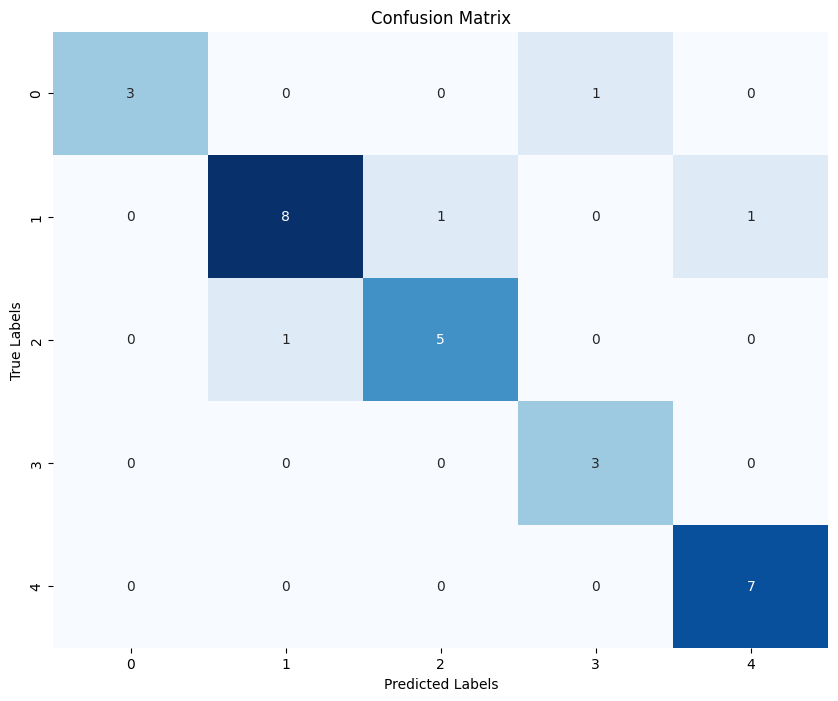

In [67]:
import seaborn as sns 
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

# Load the test CSV file
test_df = pd.read_csv('dataset/test.csv')

# List to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over each row in the test dataframe
for index, row in test_df.iterrows():
    # Load and preprocess the test image
    img_path = 'dataset/alien_test/' + row['Image_id']
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image
    
    # Use the model to make predictions
    predictions = model.predict(img)
    
    # Get the predicted class label
    predicted_class = np.argmax(predictions, axis=-1)[0]
    
    # Append the true label and predicted label to the lists
    true_labels.append(row['labels'])
    predicted_labels.append(predicted_class)

# Convert lists to numpy arrays for evaluation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Print confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Generate a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [68]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8666666666666667


## Conclusion

* Our custom model has predicted 26 out of 30 images correctly which is a satisfactory result.
* Test Accuracy of the model is 0.87.
* We can further improve the model by collecting more data, using different architectures, or tuning the hyperparameters.